In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
RANDOM_STATE = 100



In [2]:
df = pd.read_csv("heartdata.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
print("Shape:", df.shape)
print(df.dtypes)
df['target'].value_counts()


Shape: (303, 14)
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


target
1    165
0    138
Name: count, dtype: int64

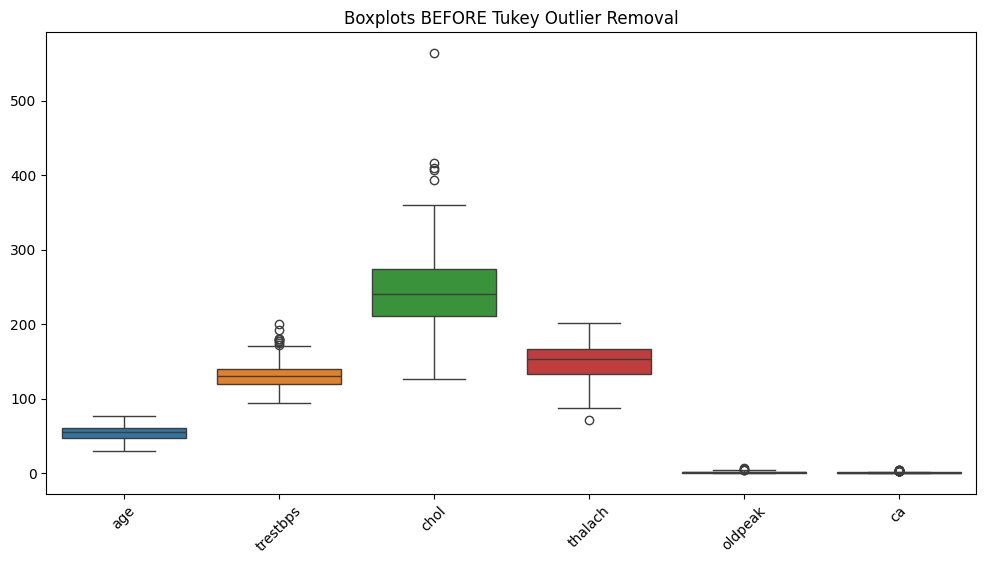

In [4]:
numeric_features = ['age','trestbps','chol','thalach','oldpeak','ca']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features])
plt.title("Boxplots BEFORE Tukey Outlier Removal")
plt.xticks(rotation=45)
plt.show()


In [5]:
def remove_outliers_tukey(df, features, k=1.5):
    df_clean = df.copy()
    for col in features:
        if np.issubdtype(df_clean[col].dtype, np.number):
            q1 = df_clean[col].quantile(0.25)
            q3 = df_clean[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - k * iqr
            upper = q3 + k * iqr
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

numeric_features = ['age','trestbps','chol','thalach','oldpeak','ca']  # adjust if dataset differs
df_clean = remove_outliers_tukey(df, numeric_features)
print("After Tukey removal:", df_clean.shape)


After Tukey removal: (263, 14)


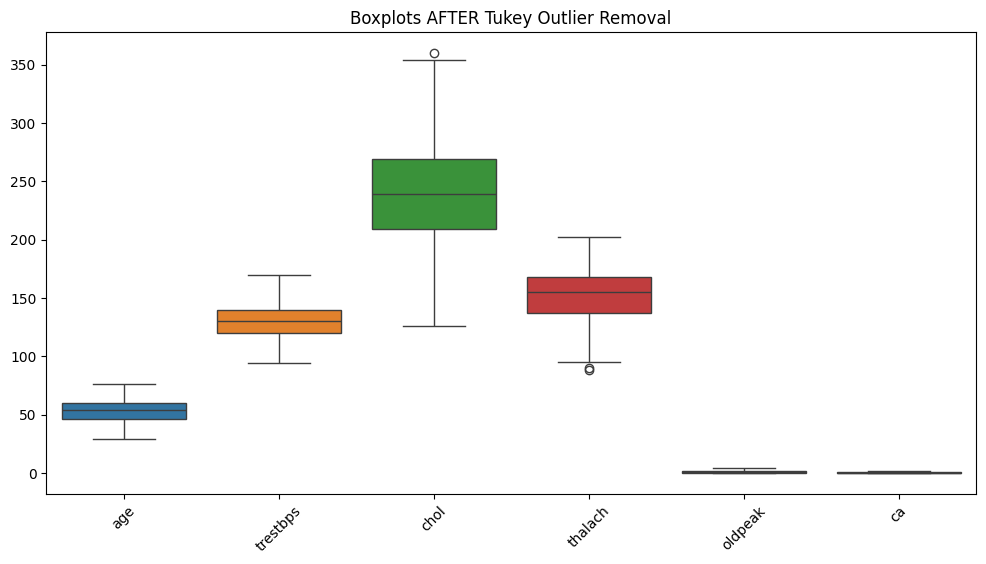

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[numeric_features])
plt.title("Boxplots AFTER Tukey Outlier Removal")
plt.xticks(rotation=45)
plt.show()


In [7]:
cat_features = ['sex','cp','fbs','restecg','exang','slope','thal']  # adjust as needed
num_features = [c for c in df_clean.columns if c not in cat_features + ['target']]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

X = df_clean.drop('target', axis=1)
y = df_clean['target']

X_processed = preprocessor.fit_transform(X)
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']

smote = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X_processed, y)


Numeric features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


/Users/sosee/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [8]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']

X_pre = preprocessor.fit_transform(X)
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
ohe_cols = ohe.get_feature_names_out(cat_features) if hasattr(ohe, 'get_feature_names_out') else []
transformed_feature_names = num_features + list(ohe_cols)

print("Transformed feature count:", X_pre.shape[1])



Transformed feature count: 19


In [9]:
lr_for_select = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
lr_for_select.fit(X_pre, y)

selector = SelectFromModel(lr_for_select, prefit=True, threshold='median')  
selected_mask = selector.get_support()
selected_features = [name for name, keep in zip(transformed_feature_names, selected_mask) if keep]
print("Selected features (after SelectFromModel):", selected_features)


Selected features (after SelectFromModel): ['oldpeak', 'ca', 'sex_1', 'cp_1', 'cp_2', 'cp_3', 'exang_1', 'slope_2', 'thal_2', 'thal_3']


In [10]:
try:
    from ydata_profiling import ProfileReport
    profile = ProfileReport(df_clean, title="Pandas Profiling Report")
    profile.to_file("ydata_profiling_report.html")
    print("Profiling report saved to ydata_profiling_report.html")
except ImportError:
    print("ydata-profiling not found. Please install it by running '%pip install ydata-profiling'")

/Users/sosee/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sosee/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 206.51it/s]

Profiling report saved to ydata_profiling_report.html



Displaying Correlation Heatmap...


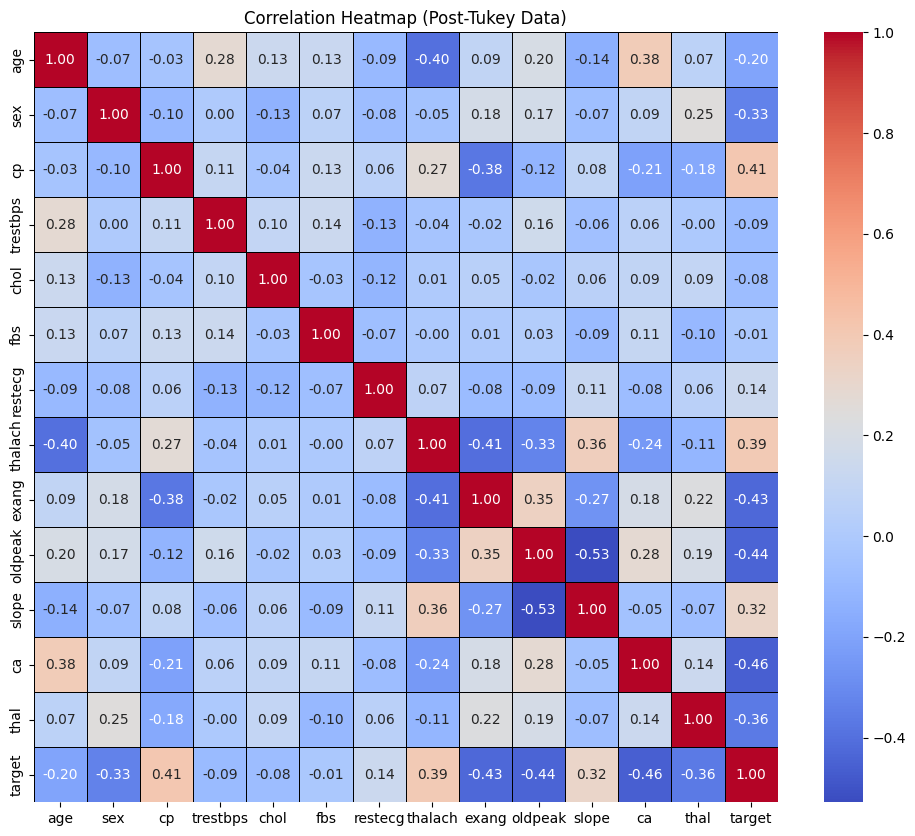

In [11]:
print("\nDisplaying Correlation Heatmap...")

plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(),
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            linecolor='black')
plt.title('Correlation Heatmap (Post-Tukey Data)')
plt.show()




In [12]:
X_trans = pd.DataFrame(X_pre, columns=transformed_feature_names)
X_selected = X_trans[selected_features]
print("X_selected shape:", X_selected.shape)



X_selected shape: (263, 10)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (210, 10) Test size: (53, 10)


In [14]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE, class distribution:", np.bincount(y_train_res))



After SMOTE, class distribution: [121 121]


/Users/sosee/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [15]:
lr = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
print("LogReg Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LogReg ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_lr))


LogReg Accuracy: 0.8490566037735849
LogReg ROC-AUC: 0.9266862170087976
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        22
           1       0.87      0.87      0.87        31

    accuracy                           0.85        53
   macro avg       0.84      0.84      0.84        53
weighted avg       0.85      0.85      0.85        53



In [16]:
params = {'n_neighbors': list(range(1, 21))}
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, params, cv=5, scoring='accuracy')
grid_knn.fit(X_train_res, y_train_res)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Best K:", grid_knn.best_params_)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN ROC-AUC:", roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_knn))


Best K: {'n_neighbors': 19}
KNN Accuracy: 0.8490566037735849
KNN ROC-AUC: 0.9156891495601174
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        22
           1       0.90      0.84      0.87        31

    accuracy                           0.85        53
   macro avg       0.84      0.85      0.85        53
weighted avg       0.85      0.85      0.85        53



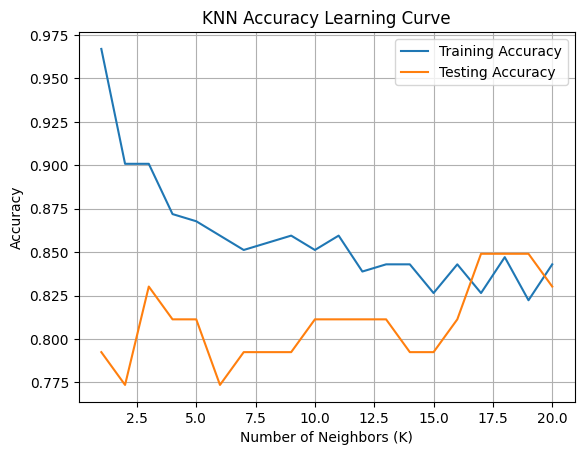

In [17]:
k_values = list(range(1, 21))
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_res, y_train_res)
    
    train_acc = knn_model.score(X_train_res, y_train_res)
    test_acc = knn_model.score(X_test, y_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_values, train_accuracies)
plt.plot(k_values, test_accuracies)
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy Learning Curve")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.grid(True)
plt.show()


In [18]:
svc = SVC(probability=True, random_state=RANDOM_STATE)

params_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(svc, params_svm, cv=5, scoring='accuracy')
grid_svc.fit(X_train_res, y_train_res)

best_svc = grid_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

print("Best SVM:", grid_svc.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
print("SVM ROC-AUC:", roc_auc_score(y_test, best_svc.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_svc))


Best SVM: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Accuracy: 0.8301886792452831
SVM ROC-AUC: 0.9046920821114369
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        22
           1       0.89      0.81      0.85        31

    accuracy                           0.83        53
   macro avg       0.83      0.84      0.83        53
weighted avg       0.84      0.83      0.83        53



In [19]:
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=RANDOM_STATE
)

rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_rf))


RF Accuracy: 0.8301886792452831
RF ROC-AUC: 0.8636363636363636
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.82      0.90      0.86        31

    accuracy                           0.83        53
   macro avg       0.83      0.82      0.82        53
weighted avg       0.83      0.83      0.83        53



In [20]:
adb = AdaBoostClassifier(
    n_estimators=50,
    random_state=RANDOM_STATE
)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('adb', adb)],
    voting='soft'
)

ensemble.fit(X_train_res, y_train_res)
y_pred_ens = ensemble.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ens))
print("Ensemble ROC-AUC:", roc_auc_score(y_test, ensemble.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_ens))


Ensemble Accuracy: 0.8301886792452831
Ensemble ROC-AUC: 0.8856304985337243
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.82      0.90      0.86        31

    accuracy                           0.83        53
   macro avg       0.83      0.82      0.82        53
weighted avg       0.83      0.83      0.83        53



In [21]:
summary = pd.DataFrame({
    'Model': ['LogReg', 'KNN', 'SVM', 'RF', 'Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svc),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_ens)
    ],
    'ROC_AUC': [
        roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, best_svc.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, ensemble.predict_proba(X_test)[:,1])
    ]
})

summary.sort_values("ROC_AUC", ascending=False)


,Model,Accuracy,ROC_AUC
0,LogReg,0.849057,0.926686
1,KNN,0.849057,0.915689
2,SVM,0.830189,0.904692
4,Ensemble,0.830189,0.885630
3,RF,0.830189,0.863636


In [22]:
best_model_name = summary.sort_values("ROC_AUC", ascending=False).iloc[0]['Model']
print("Best Model:", best_model_name)

model_dict = {
    'LogReg': lr,
    'KNN': best_knn,
    'SVM': best_svc,
    'RF': rf,
    'Ensemble': ensemble
}

best_model = model_dict[best_model_name]

joblib.dump(best_model, "best_model.joblib")
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(selector, "selector.joblib")
joblib.dump(selected_features, "selected_features.joblib")

print("Model + preprocessing saved.")


Best Model: LogReg
Model + preprocessing saved.


In [23]:
def plot_confusion_and_roc(model, X_test, y_test, model_name):
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_name}_roc_curve.png")
    plt.show()


In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


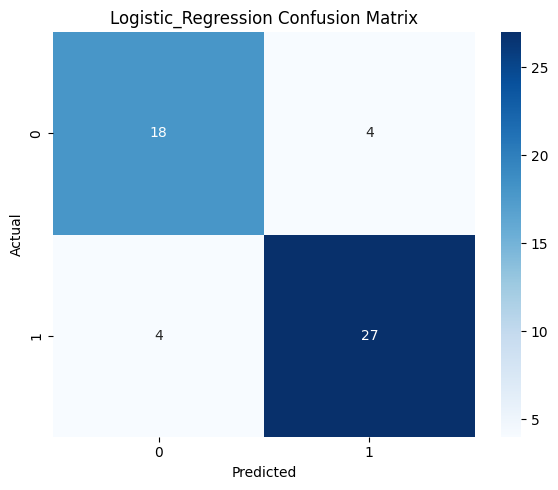

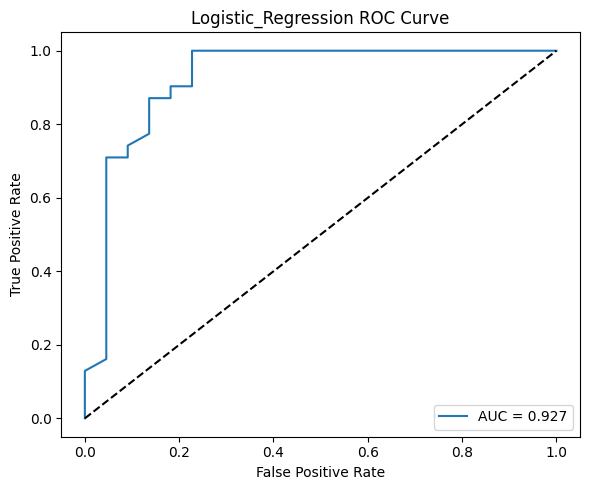

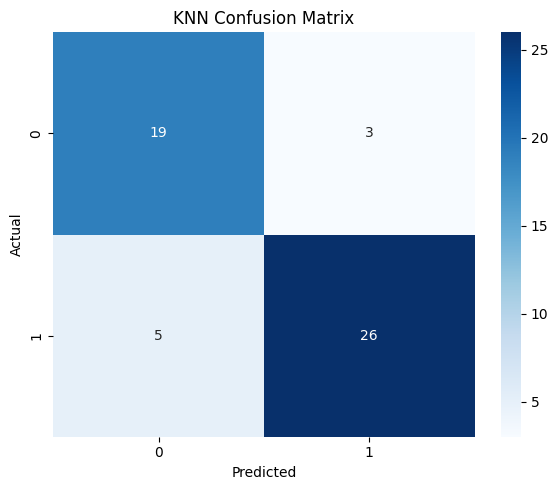

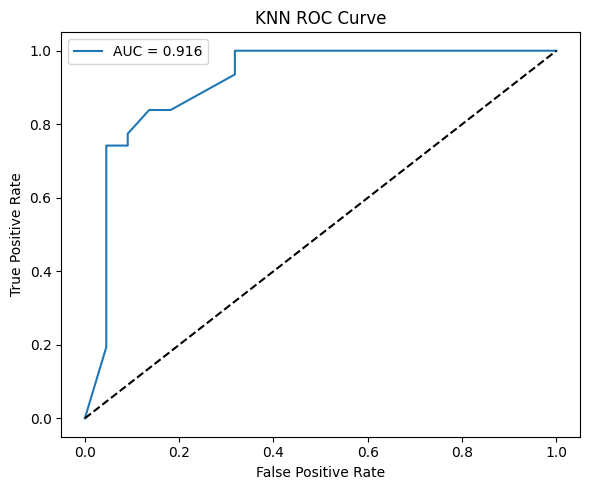

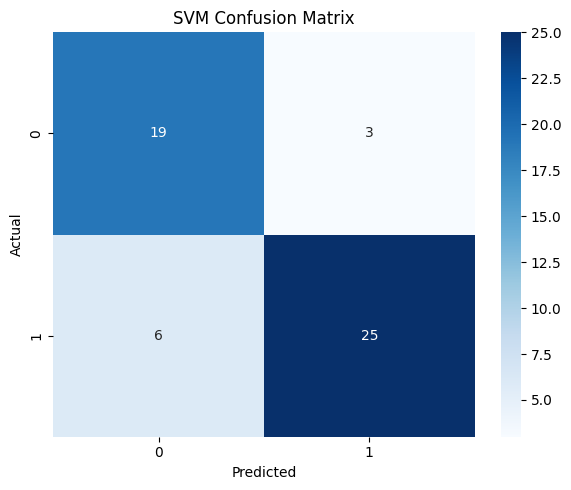

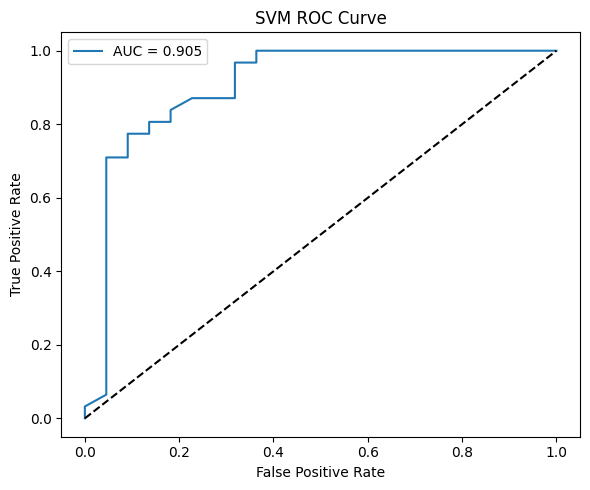

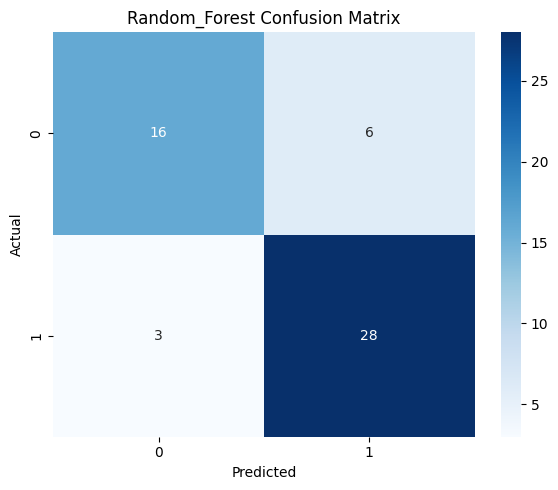

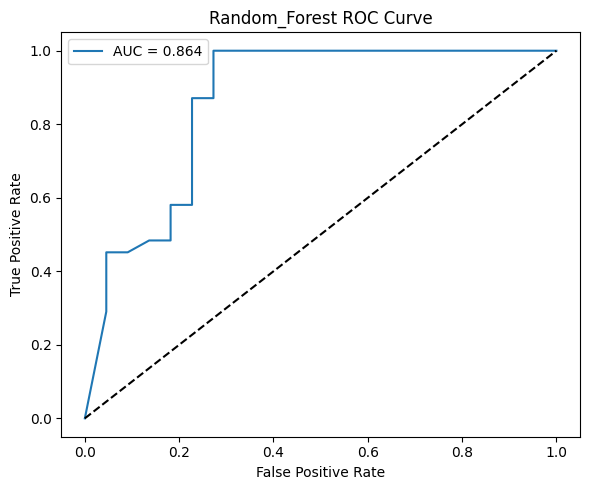

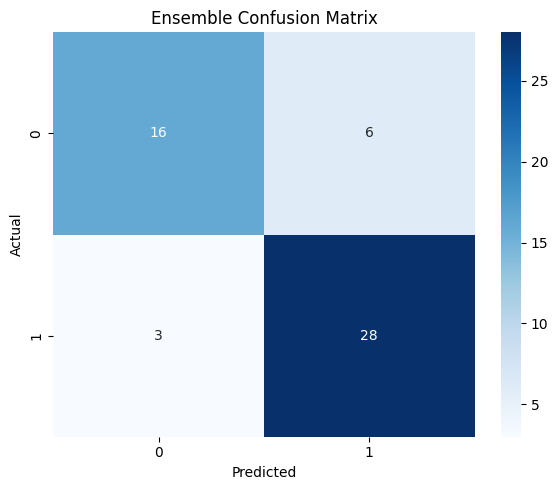

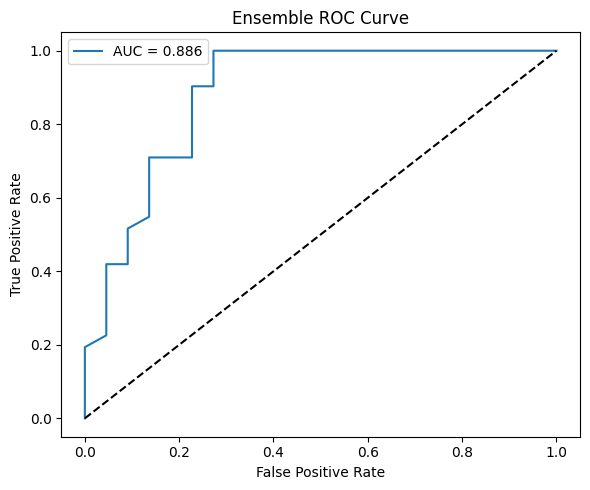

In [25]:
# Generate confusion matrices and ROC curves for all models

plot_confusion_and_roc(lr, X_test, y_test, "Logistic_Regression")
plot_confusion_and_roc(best_knn, X_test, y_test, "KNN")
plot_confusion_and_roc(best_svc, X_test, y_test, "SVM")
plot_confusion_and_roc(rf, X_test, y_test, "Random_Forest")
plot_confusion_and_roc(ensemble, X_test, y_test, "Ensemble")


